In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Look at info in the tables by first using inspector to get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [25]:
# Use inspector to look at the column names and types for each table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [26]:
# Use inspector to look at the column names and types for each table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [252]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year = dt.date(2017,8,23) - dt.timedelta(weeks=52)
print(previous_year)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.station, measurement.prcp).filter(measurement.date >= previous_year).all()
# prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data).set_index('date')
prcp_df
# Sort the dataframe by date
prcp_df = prcp_df.sort_values(['date']).dropna()
prcp_df




2016-08-24


,station,prcp
date,,
2016-08-24,USC00519397,0.08
2016-08-24,USC00519281,2.15
2016-08-24,USC00514830,2.28
2016-08-24,USC00513117,2.15
2016-08-24,USC00516128,1.45
...,...,...
2017-08-22,USC00519523,0.00
2017-08-23,USC00519523,0.08
2017-08-23,USC00519397,0.00


date    datetime64[ns]
prcp           float64
dtype: object


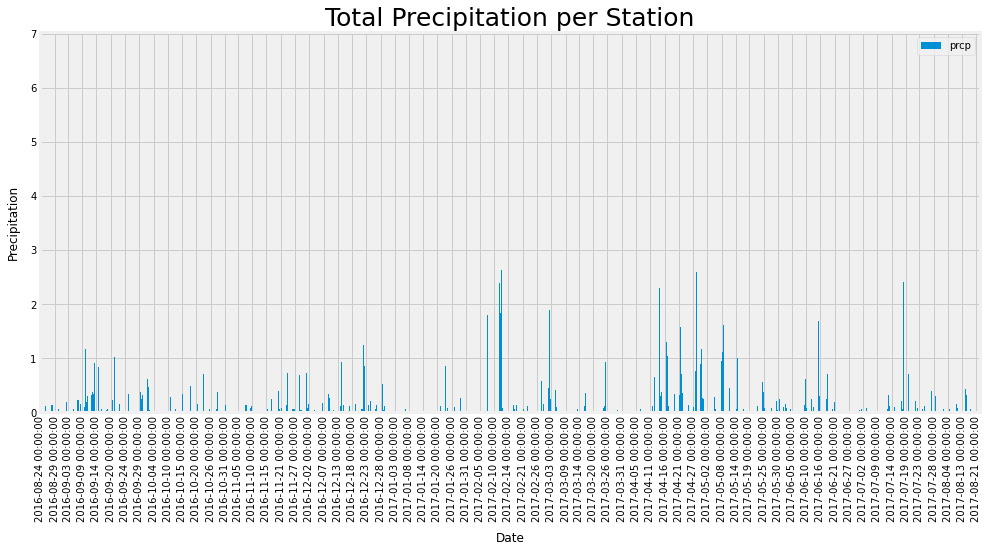

In [261]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
%matplotlib inline

prcp_df_simp = prcp_df.drop(columns=['station']).reset_index()
prcp_df_simp['date'] = pd.to_datetime(prcp_df_simp['date'])
print(prcp_df_simp.dtypes)
prcp_df_simp = prcp_df_simp.set_index(['date'])
prcp_df_simp


# Plot graph
fig, ax = plt.subplots(figsize=(15,7))
prcp_df_simp.plot(kind='bar', ax=ax)
ax.bar(prcp_df_simp.index, prcp_df_simp['prcp'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Total Precipitation per Station", fontsize=25)
plt.xlabel("Date", labelpad=10)
plt.ylabel("Precipitation", labelpad=10)

plt.show()


In [235]:
# Use Pandas Plotting with Matplotlib to plot the data

# Convert date to actual datetime data type
prcp_df_grouped = prcp_df.reset_index()
print(f"before change:\n{prcp_df_grouped.dtypes}")
prcp_df_grouped['date'] = pd.to_datetime(prcp_df_grouped['date'])
print(f"after dtype change:\n{prcp_df_grouped.dtypes}")

# Group data by dates and station and use sum to total prcp readings per date and station
prcp_df_grouped_station = prcp_df_grouped.groupby(['date', 'station']).sum()
prcp_df_grouped_station



before change:
date        object
station     object
prcp       float64
dtype: object
after dtype change:
date       datetime64[ns]
station            object
prcp              float64
dtype: object


prcp
date       station          
2016-08-24 USC00513117  2.15
           USC00514830  2.28
           USC00516128  1.45
           USC00517948  0.00
           USC00519281  2.15
...                      ...
2017-08-22 USC00519523  0.00
2017-08-23 USC00514830  0.00
           USC00516128  0.45
           USC00519397  0.00
           USC00519523  0.08

[2223 rows x 1 columns]

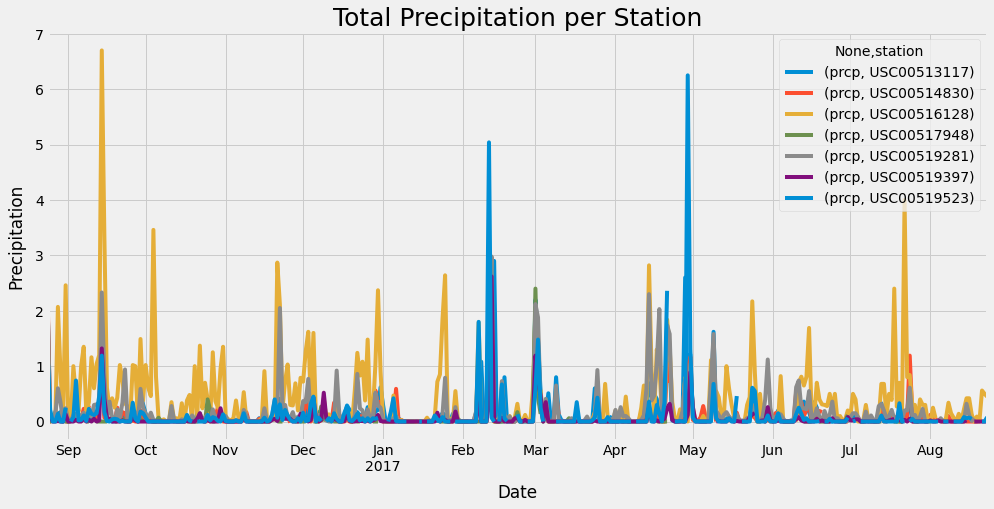

In [232]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))
prcp_df_grouped_station.unstack().plot(ax=ax)
plt.title("Total Precipitation per Station", fontsize=25)
plt.xlabel("Date", labelpad=10)
plt.ylabel("Precipitation", labelpad=10)
plt.show()


In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary = prcp_df['prcp'].describe()
prcp_summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [89]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,
        func.min(measurement.tobs), 
        func.max(measurement.tobs),
        func.avg(measurement.tobs)]
temps_active_station = session.query(*sel). \
    filter(measurement.station == 'USC00519281').all()
temps_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [223]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, 
        measurement.station,
        measurement.tobs]
        
data_active_station = session.query(*sel). \
    filter(measurement.date >= previous_year). \
    filter(measurement.station == 'USC00519281').all()

# Make into dataframe and check datatypes
data_active_station = pd.DataFrame(data_active_station)
data_active_station = data_active_station.rename(columns={"tobs" : "temperature"})
print(data_active_station.dtypes)
data_active_station


date            object
station         object
temperature    float64
dtype: object


,date,station,temperature
0,2016-08-24,USC00519281,77.0
1,2016-08-25,USC00519281,80.0
2,2016-08-26,USC00519281,80.0
3,2016-08-27,USC00519281,75.0
4,2016-08-28,USC00519281,73.0
...,...,...,...
346,2017-08-14,USC00519281,77.0
347,2017-08-15,USC00519281,77.0
348,2017-08-16,USC00519281,76.0
349,2017-08-17,USC00519281,76.0


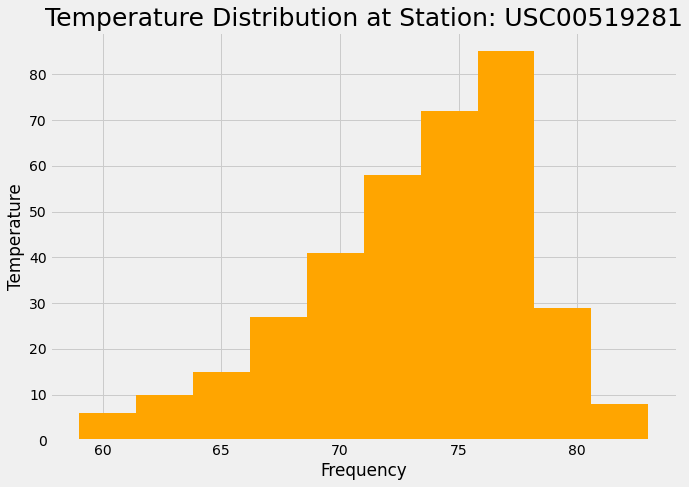

In [229]:
# Plot results as histogram
plt.figure(figsize=(10,7))
plt.hist(data_active_station['temperature'], color='orange')
plt.title("Temperature Distribution at Station: USC00519281", fontsize=25)
plt.ylabel("Temperature")
plt.xlabel("Frequency")
plt.show()

# Close session

In [230]:
# Close Session
session.close()